In [1]:
using MGVInference

In [25]:
fft_gp_model = "../test/test_models/fft_gp.jl"
open(fft_gp_model, "r") do io
    map(println, readlines(io))
end
include(fft_gp_model)

# This file is a part of MGVInference.jl, licensed under the MIT License (MIT).

import Base: *, adjoint
import AbstractFFTs
import FFTW: plan_r2r, DHT
import ForwardDiff
import Random: randn, MersenneTwister, MvNormal
import ValueShapes: NamedTupleDist
import Zygote
import LinearAlgebra: Diagonal
using Debugger

_dims = 1024
_k = [i < _dims / 2 ? i : _dims-i for i = 0:_dims-1]

# Define the harmonic transform operator as a matrix-like object
_ht = plan_r2r(zeros(_dims), DHT)

# Unfortunately neither Zygote nor ForwardDiff support planned Hartley
# transformations. While Zygote does not support AbstractFFTs.ScaledPlan,
# ForwardDiff does not overload the appropriate methods from AbstractFFTs.
function _plan_dual_product(trafo::AbstractFFTs.Plan, u::Vector{ForwardDiff.Dual{T, V, N}}) where {T, V, N}
    # Unpack AoS -> SoA
    vs = ForwardDiff.value.(u)
    ps = mapreduce(ForwardDiff.partials, vcat, u)
    # Actual computation
    val = trafo * vs
    jvp = trafo * ps
    # Pack SoA -> 

1024-element Array{Float64,1}:
 -0.2182971373018973
 -1.7218447499307976
  0.603715678803879
 -0.21179751899630508
 -0.44777338300787084
 -0.4476889572053994
  2.013315941253755
  0.7635310957132931
 -0.0981351745482496
  0.14246898420247958
 -2.893510412007984
  0.271258492099812
  0.49524834448070404
  ⋮
 -1.090434633063569
 -0.771555885680558
  0.9922491025400911
  0.6487004030213025
  0.07849005150595895
  0.8694835686064477
 -0.06439913347176371
 -0.5746580643264838
 -1.3384515439734235
  1.3028154769312215
 -0.042217192465364914
 -0.45191818938085576

In [3]:
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [4]:
data = rand(model(true_params), 1)[1];

In [5]:
_common_grid = [1:_dims...];

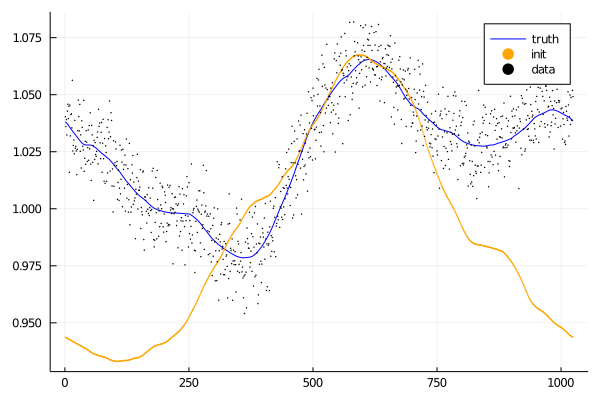

In [6]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, markerstrokewidth=0, markersize=1, label="init")
    scatter!(_common_grid, MGVInference.unshaped(data), markercolor=:black, markerstrokewidth=0, markersize=1, label="data")
end
plot()
init_plots()

In [7]:
typeof(map(ForwardDiff.Dual, true_params, true_params)) <: Array{ForwardDiff.Dual{T, V, N}} where {T, V, N}

true

In [24]:
FwdDerJacobianFunc(_mean)(true_params)*map(ForwardDiff.Dual, true_params, true_params)

1024-element Array{ForwardDiff.Dual{Nothing,Float64,1},1}:
 Dual{Nothing}(0.03889664958128728,0.03889664958128728)
 Dual{Nothing}(0.03862392303242393,0.03862392303242393)
 Dual{Nothing}(0.03835846703394817,0.03835846703394817)
 Dual{Nothing}(0.03809222572505251,0.03809222572505251)
 Dual{Nothing}(0.03781498082049222,0.03781498082049222)
 Dual{Nothing}(0.037533934711919695,0.037533934711919695)
 Dual{Nothing}(0.03723320965704391,0.03723320965704391)
 Dual{Nothing}(0.0369205029911717,0.0369205029911717)
 Dual{Nothing}(0.03659686954103119,0.03659686954103119)
 Dual{Nothing}(0.03627229708049993,0.03627229708049993)
 Dual{Nothing}(0.035959505003717536,0.035959505003717536)
 Dual{Nothing}(0.03564531184277031,0.03564531184277031)
 Dual{Nothing}(0.0353336544648698,0.0353336544648698)
               ⋮
 Dual{Nothing}(0.04133327023088409,0.04133327023088409)
 Dual{Nothing}(0.0412006235527077,0.0412006235527077)
 Dual{Nothing}(0.04106488296333773,0.04106488296333773)
 Dual{Nothing}(0.0409094581860

In [26]:
@run ForwardDiff.gradient(t -> FwdDerJacobianFunc(_mean)(true_params)*t, zeros(size(true_params)))

LoadError: Debugger.jl needs to be run in a Julia REPL

In [14]:
adjoint(FwdDerJacobianFunc(_mean)(true_params))*true_params

LoadError: ArgumentError: FFTW plan applied to wrong-size array

In [10]:
first_iteration = mgvi_kl_optimize_step(model, data, starting_point; jacobian_func=FwdRevADJacobianFunc, residual_sampler=FullResidualSampler)

display(hcat(first_iteration, true_params))

LoadError: InterruptException:

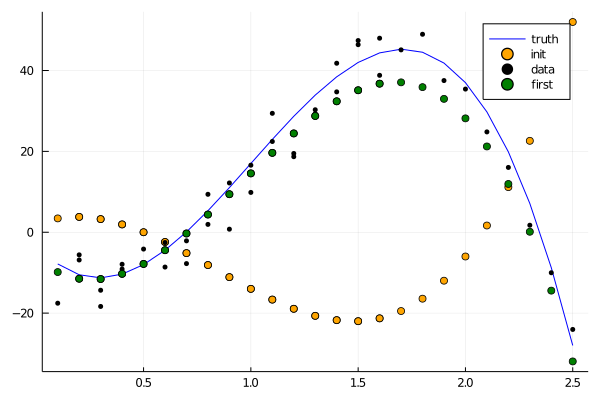

In [9]:
plot_iteration = (params, label) -> let
    #error_mat = mgvi_kl_errors(full_model, params)
    #display(error_mat)
    #errors = sqrt.(error_mat[diagind(error_mat)])
    #yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    #scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    scatter!(_common_grid, _mean(params), markercolor=:green, label=label)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [10]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#13 (generic function with 1 method)

5×2 Array{Float64,2}:
 -0.642859  -0.3
 -1.09381   -1.5
  0.164922   0.2
 -0.427679  -0.5
 -1.86348    0.3

5×2 Array{Float64,2}:
 -0.77061    -0.3
 -1.79013    -1.5
  0.0970204   0.2
 -0.0560734  -0.5
 -0.0184248   0.3

5×2 Array{Float64,2}:
 -0.507446  -0.3
 -1.41861   -1.5
  0.194      0.2
 -0.487066  -0.5
  0.281601   0.3

5×2 Array{Float64,2}:
 -0.389793  -0.3
 -1.52278   -1.5
  0.199986   0.2
 -0.496003  -0.5
  0.277523   0.3

5×2 Array{Float64,2}:
 -0.376284  -0.3
 -1.52432   -1.5
  0.198996   0.2
 -0.493958  -0.5
  0.253573   0.3

5×2 Array{Float64,2}:
 -0.541081  -0.3
 -1.39662   -1.5
  0.193433   0.2
 -0.486439  -0.5
  0.361641   0.3

5×2 Array{Float64,2}:
 -0.390828   -0.3
 -1.42505    -1.5
  0.190735    0.2
 -0.478237   -0.5
  0.0350358   0.3

5×2 Array{Float64,2}:
 -0.507443  -0.3
 -1.4186    -1.5
  0.194      0.2
 -0.487065  -0.5
 -0.281604   0.3

5×2 Array{Float64,2}:
 -0.210508  -0.3
 -1.69418   -1.5
  0.211135   0.2
 -0.520239  -0.5
 -0.276579   0.3

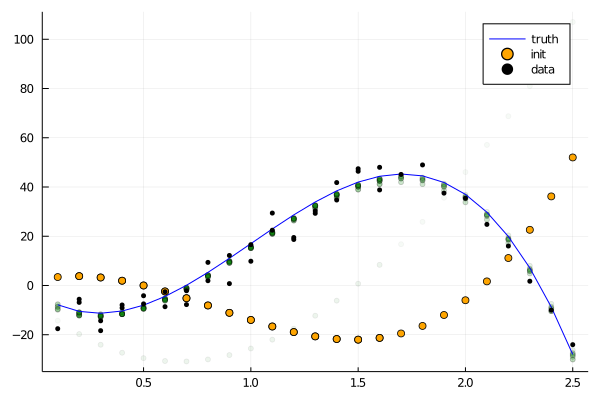

In [29]:
plt = scatter()
next_iteration = first_iteration
for i in 1:8
    display(hcat(next_iteration, true_params))
    next_iteration = mgvi_kl_optimize_step(model, data, next_iteration; residual_sampler=ImplicitResidualSampler)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

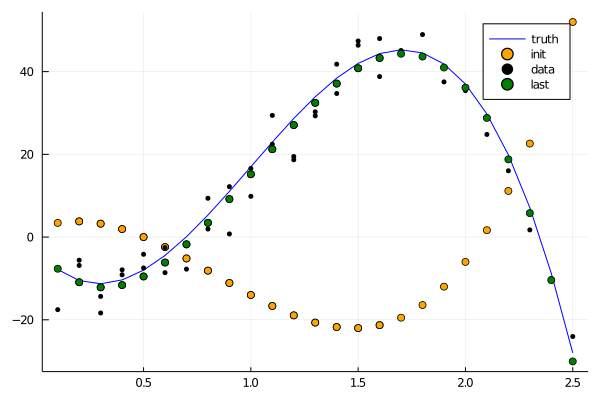

In [30]:
plot()
init_plots()
plot_iteration(next_iteration, "last")